In [32]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.svm import SVC
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler)
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    make_scorer)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
    validation_curve,
    GridSearchCV,
    RandomizedSearchCV,
    HalvingRandomSearchCV)


%matplotlib inline

In [6]:
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)
df.head()
X=df.iloc[:,2:].values
y=df.iloc[:,1].values
le=LabelEncoder()
y=le.fit_transform(y)
le.classes_
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=1)

In [10]:
pipe_svc=make_pipeline(
    StandardScaler(),
    SVC(random_state=1))

param_range=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid=[{'svc__C':param_range,
             'svc__kernel':['linear']},
             {'svc__C':param_range,
              'svc__gamma':param_range,
              'svc__kernel':['rbf']}]

gs=GridSearchCV(
    estimator=pipe_svc,
    scoring='accuracy',
    cv=10,
    refit=True,
    n_jobs=-1,
    param_grid=param_grid
)

gs=gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [11]:
clf=gs.best_estimator_
clf.fit(X_train,y_train)
print('Test accuracy: %.3f' % clf.score(X_test,y_test))

Test accuracy: 0.974


Random Search 

In [14]:
param_range=sp.stats.loguniform(0.0001,1000.0)
np.random.seed(1)
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [17]:
pipe_svc=make_pipeline(
    StandardScaler(),
    SVC(random_state=1))

param_grid=[{'svc__C':param_range,
            'svc__kernel':['linear']},
            {'svc__C':param_range,
            'svc__gamma':param_range,
            'svc__kernel':['rbf']}]

rs=RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        cv=10,
                        n_iter=20,
                        refit=True,
                        random_state=1,
                        n_jobs=-1)

rs=rs.fit(X_train,y_train)
print(rs.best_score_)
print(rs.best_params_)


0.9780676328502416
{'svc__C': 0.05971247755848464, 'svc__kernel': 'linear'}


Halving Search

In [22]:
hs=HalvingRandomSearchCV(
    estimator=pipe_svc,
    param_distributions=param_grid,
    n_candidates='exhaust',
    resource='n_samples',
    factor=1.5,
    random_state=1,
    n_jobs=-1)

hs=hs.fit(X_train,y_train)
print(hs.best_score_)
print(hs.best_params_)

0.9617647058823529
{'svc__C': 4.934834261073341, 'svc__kernel': 'linear'}


nested cross validation

In [23]:
param_range=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]

param_grid=[{'svc__C':param_range,
            'svc__kernel':['linear']},
            {'svc__C':param_range,
            'svc__gamma':param_range,
            'svc__kernel':['rbf']}]

gs=GridSearchCV(estimator=pipe_svc,
                param_grid=param_grid,
                scoring='accuracy',
                cv=2,)

scores=cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [24]:
from sklearn.tree import DecisionTreeClassifier
gs=GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],
    scoring='accuracy',
    cv=2)
scores=cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


CV accuracy: 0.934 +/- 0.016


In [26]:
pipe_svc.fit(X_train,y_train)
y_pred=pipe_svc.predict(X_test)
confmat=confusion_matrix(y_true=y_test,y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


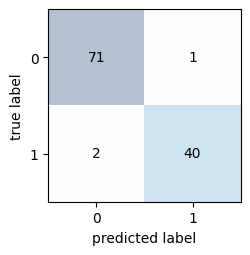

In [27]:
fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [31]:
pre_val=precision_score(y_true=y_test,y_pred=y_pred)
print('Precision: %.3f' % pre_val)
rec_val=recall_score(y_true=y_test,y_pred=y_pred)
print('Recall: %.3f' % rec_val)
f1_val=f1_score(y_true=y_test,y_pred=y_pred)
print('F1: %.3f' % f1_val)
mcc_val=matthews_corrcoef(y_true=y_test,y_pred=y_pred)
print('MCC: %.3f' % mcc_val)

Precision: 0.976
Recall: 0.952
F1: 0.964
MCC: 0.943


In [33]:
c_gamma_range=[0.01,0.1,1.0,10.0]
param_grid=[{'svc__C':c_gamma_range,
            'svc__kernel':['linear']},
            {'svc__C':c_gamma_range,
            'svc__gamma':c_gamma_range,
            'svc__kernel':['rbf']}]
scorer=make_scorer(f1_score,pos_label=0)
gs=GridSearchCV(estimator=pipe_svc,
                param_grid=param_grid,
                scoring=scorer,
                cv=10)

gs=gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
